In [15]:
use_gdrive = True # @param {type:"boolean"}

RESULTS_PATH = "results2"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab23/results2"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import sys

# Lab files
![ ! -d 'infoseclab_23' ] && git clone https://github.com/ethz-spylab/infoseclab_23.git
%cd infoseclab_23
!git pull https://github.com/ethz-spylab/infoseclab_23.git
%cd ..
if "infoseclab_23" not in sys.path:
  sys.path.append("infoseclab_23")

/content/infoseclab_23
From https://github.com/ethz-spylab/infoseclab_23
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


# Imports

In [17]:
import infoseclab
from infoseclab import ShadowModels, utils, evaluation
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import sklearn
import warnings
from zipfile import ZipFile


# Membership Inference

In this part of the lab, you will create a membership inference attack, with a twist:
you do not know which shadow models were trained on which samples.

First, load the predictions.

In [18]:
# Load data
activations_fit = ShadowModels.activations_fit        # pre-softmax activations from shadow models to construct your attack (50000 x 127 x 10)
activations_attack = ShadowModels.activations_attack  # pre-softmax activations from the target model to attack (50000 x 10)
labels = ShadowModels.labels                          # the class labels of all samples (50000)
training_splits = ShadowModels.training_splits        # train-test vector; -1 for test samples, 1/0 (member/non-member) for training samples (50000)

num_samples, num_models, num_classes = activations_fit.shape
assert activations_attack.shape == (num_samples, num_classes)
assert labels.shape == (num_samples,)
assert training_splits.shape == (num_samples,)

# Mask that is True for all samples with a known target membership label
training_mask = (training_splits != -1)


**Implement your membership inference attack in the following cell.**

Remember that your output should be a NumPy array
containing attack scores for *all* samples,
but we only consider samples where the corresponding `training_mask` entry
is `False` for grading.

The following code performs a dummy attack that ignores all shadow model outputs.

In [19]:
###### reference the liRA paper (hinge loss)
def derive_score(scores, ground_truth_label_index):
  z = scores[ground_truth_label_index]
  max_value_except_myself = max([scores[i] for i in range(len(scores)) if i != ground_truth_label_index])
  return z - max_value_except_myself

def compute_scores_fit(activation_fit, labels):
  final_scores = []
  for sample_index, samples in enumerate(activation_fit):
    final_scores.append([derive_score(model_output, labels[sample_index])  for model_output in samples])
  return final_scores

def compute_scores_attack(activations_attack, labels):
  final_scores = []
  for sample_index, samples in enumerate(activations_attack):
    final_scores.append(derive_score(samples, labels[sample_index]))
  return final_scores


activation_fit_scores = compute_scores_fit(activations_fit.tolist(), labels.tolist())
activations_attack_scores = compute_scores_attack(activations_attack.tolist(), labels.tolist())

###### a bit whacky, but somehow it works?
my_attack_scores = []
for sample_index, activation_fit_score in enumerate(activation_fit_scores):
  attack_output_score = activations_attack_scores[sample_index]
  activation_fit_score_array = np.array(activation_fit_score)
  #### sample hardness
  mean_score = np.mean(activation_fit_score_array)
  #### how far away from the mean
  my_attack_scores.append( (attack_output_score - mean_score) / mean_score )

attack_scores = np.array(my_attack_scores, dtype='float32')

# Save scores
utils.save_attack_scores(os.path.join(RESULTS_PATH, "attack_scores.npy"), attack_scores)

My attack TPR @ FPR 1.00%: 8.38%


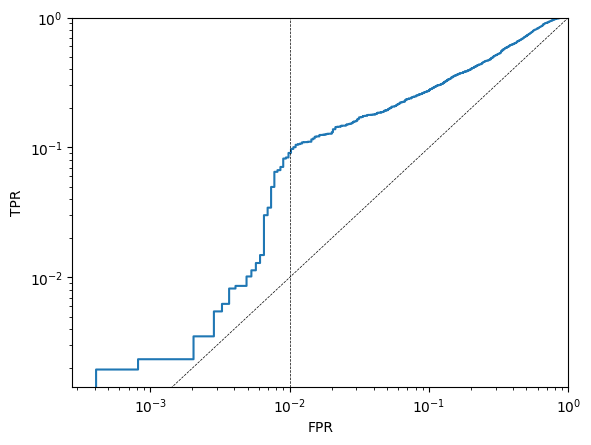

In [20]:
# You can visualize the TPR vs. FPR of your attack on the training set using the following code.
# If you want to evaluate multiple attacks you can call `evaluation.eval_mia` multiple times,
# but you should set `plot_decorations = False` for all but the first call.
fig, ax = plt.subplots()
evaluation.eval_mia(
    true_splits=training_splits[training_mask],
    attack_scores=attack_scores[training_mask],
    ax=ax,
    label="My attack",
    plot_decorations=True,
)
plt.show(fig)
plt.close(fig)

# Stealing Chatbot Prompts

Enter results for the chatbot secret extraction

In [21]:
# Enter your 10 extracted secrets, 6 alphanumeric characters each
secrets = [
    "TIOsxG",
    "ur71Ct",
    "x7yQxM",
    "3PiGUk",
    "TZoP2i",
    "NofQK8",
    "6gTiO0",
    "pss410",
    "j7xE6h",
    "hmaPiB"
]

# save the secrets to an array and save it to chatbot.npy
secrets = np.array(secrets)
assert len(secrets) == 10
np.save(f"{RESULTS_PATH}/chatbot.npy", secrets)

# Create submission file (**upload `results2.zip` to moodle**)

In [22]:
!zip -j -FSr "{RESULTS_PATH}/results2.zip" {RESULTS_PATH}

updating: attack_scores.npy (deflated 6%)
updating: chatbot.npy (deflated 52%)


In [23]:
from infoseclab.submission import validate_zip2
assert validate_zip2(f"{RESULTS_PATH}/results2.zip")

Zip file is valid
